In [ ]:
import collections, gym, math, random, tqdm
import matplotlib.pyplot as mp, numpy as np, pandas as pd, torch as th
from torch.autograd import Variable

![](https://upload.wikimedia.org/wikipedia/commons/thumb/0/00/Cart-pendulum.svg/300px-Cart-pendulum.svg.png)

### Model

In [ ]:
class ShallowRectifier(th.nn.Sequential):
    def __init__(self, states, actions, units=128):
        super().__init__()
        self.model = th.nn.Sequential(
        th.nn.Linear(states, units),
        th.nn.ReLU(),
        th.nn.Linear( units, units),
        th.nn.ReLU(),
        th.nn.Linear(units,actions))

### Memory

In [ ]:
class ExperienceReplay(object):
    def __init__(self, capacity=2**20):
        self.buffer = collections.deque(maxlen=capacity)

    def push(self, state, action, reward, sprime, terminal):
        state = np.expand_dims(state, 0)
        sprime= np.expand_dims(sprime,0)

        self.buffer.append((state, action, reward, sprime, terminal))

    def sample(self, bsize=1):
        s,a,r,s_,t = zip(*random.sample(self.buffer, bsize))
        return np.concatenate(s), a, r, np.concatenate(s_), np.array(t).astype(np.float32)

    def minibatch(self, bsize=1):
        s,a,r,s_,t = self.sample(bsize)
        a = Variable(th.from_numpy(np.array(a)).long())
        s = Variable(th.from_numpy(s).float())
        s_= Variable(th.from_numpy(s_).float())
        r = Variable(th.from_numpy(np.array(r)).float())
        t = Variable(th.from_numpy(t).float())
        return s,a,r,s_,t
        
    def __len__(self):
        return len(self.buffer)

### Policy

In [ ]:
class Policy(th.nn.Module):
    def __init__(self):
        pass

class EpsilonGreed(Policy):
    def __init__(self, epsilon_init=1., epsilon_min=0.01, epsilon_decay=384):
        self.epsilon_min = epsilon_min
        self.epsilon_init= epsilon_init
        self.epsilon_decay = epsilon_decay
        self.epsilon = epsilon_init

    def decay_epsilon(self, itr):
        decay_rate = np.exp(-1.* itr / self.epsilon_decay)
        diff = (self.epsilon_init - self.epsilon_min) * decay_rate
        self.epsilon = self.epsilon_min + diff
        
    def __call__(self, logits):
        if len(logits.size()) <2: logits.unsqueeze_(0)
        if random.random() > self.epsilon:
            action = logits.max(1)[1].data[0].item()
        else:
            action = np.random.randint(0,logits.size(-1))
        return action

### Deep Q-Network

In [ ]:
class Agent:
    def __init__(self):
        pass

class DQN(Agent):
    def __init__(self, model, optim, policy, memory):
        super().__init__()
        self.memory= memory
        self.policy= policy
        self.model = model
        self.optim = optim

    def update(self, bsize=1, loss=th.nn.MSELoss(), td=0):
        s,a,r,s_,t = self.memory.minibatch(bsize)
        
        Qvalue = self.model(s).gather(1,a.unsqueeze(1)).squeeze(1)
        Qprime = self.model(s_).max(1)[0]

        Qexpect= th.autograd.Variable(reward + gamma * Qprime * (1-t))
        
        self.optim.zero_grad()
        L = loss(Qvalue,Qexpect)
        L.backward()
        self.optim.step()
        
        return L.item()
        
    def interact(self, state, epsilon=0.1):
        Q = self.model(th.from_numpy(state.astype(np.float32)))
        action = self.policy(Q)
        return action

### CartPole

In [ ]:
sim = gym.make('CartPole-v0')
states,actions = sim.observation_space.shape[0], sim.action_space.n

model = ShallowRectifier(states,actions)
optim = th.optim.Adam(model.parameters(),amsgrad=True)

agent = DQN(model=model,
            optim=optim,
            memory=ExperienceReplay(),
            policy=EpsilonGreed())

### Config

In [7]:
transitions = 2**13
bsize = 1
gamma = 0.99
interval = 128

### Simulate

In [8]:
losses, cummulative, rewards = [],0,[]
state = sim.reset()
bar = tqdm.tqdm_notebook(range(1, transitions + 1))
for T in bar:
    action = agent.interact(state)
    
    sprime, reward, terminal,_ = sim.step(action)
    
    agent.memory.push(state,action,reward,sprime,terminal)
    
    state = sprime
    cummulative += reward
    agent.policy.decay_epsilon(T)
    
    if terminal:
        state = sim.reset()
        rewards.append(cummulative)
        episode_reward = 0
        
    if len(agent.memory) > bsize:
        losses.append(agent.update(bsize))

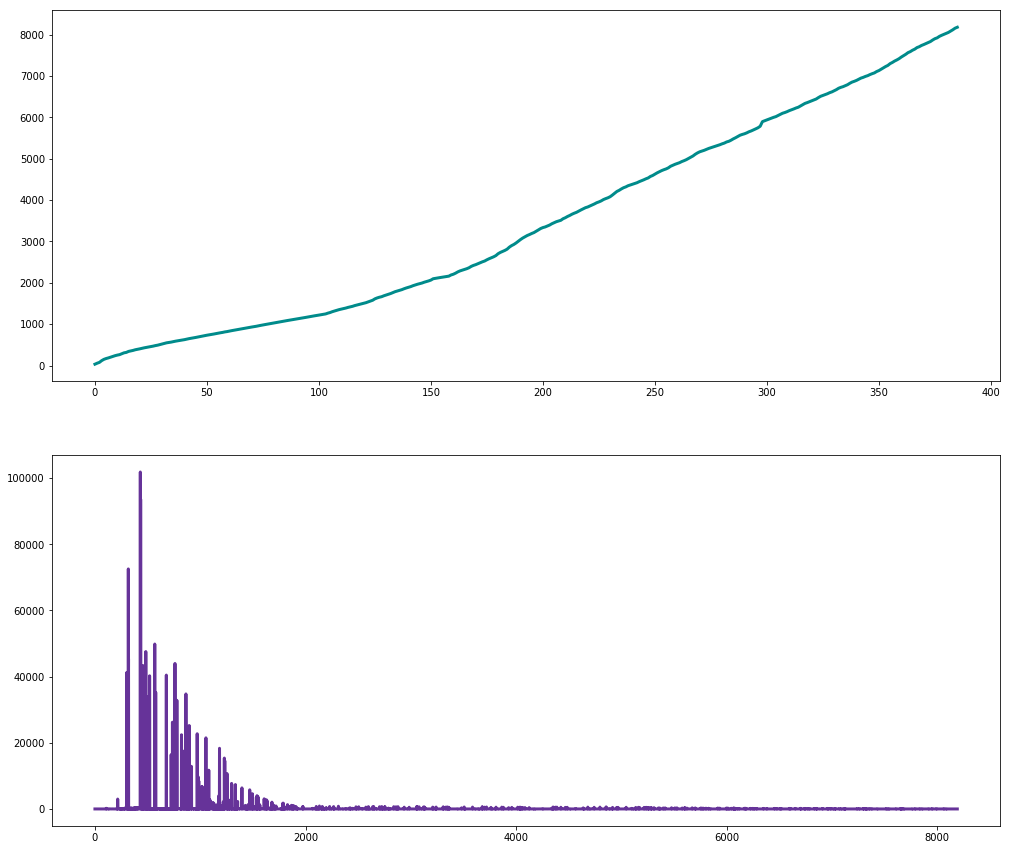

In [9]:
fig,(ax1,ax2) = mp.subplots(2,1,figsize=(17,15))
ax1.plot(rewards,label='Reward', lw=3, color='darkcyan')
ax2.plot(losses, label='Losses', lw=3, color='rebeccapurple')